# Lab 4
Lucas Street, 1874989

In [19]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas h5py
from multiprocessing import Pool

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
import h5py
from scipy import stats
from scipy.signal import argrelmax
from scipy.optimize import curve_fit

## Problem 1

We have about 26 million data points representing 30 days of measurements from a gamma-ray satellite in low Earth orbit, along with associated metadata, like the time of the measurement, the solar phase, and the longitude of the satellite relative to Earth. Each measurement represents the number of counts seen in a 0.1 second interval. Since we don't see gamma rays _that_ often, most of these counts are cosmic rays.

In [20]:
with h5py.File('gammaray_lab4.h5', 'r') as hf:
    data = np.array(hf.get('data'))

We'll plot the first 300,000 measurements to see what the data generally looks like:

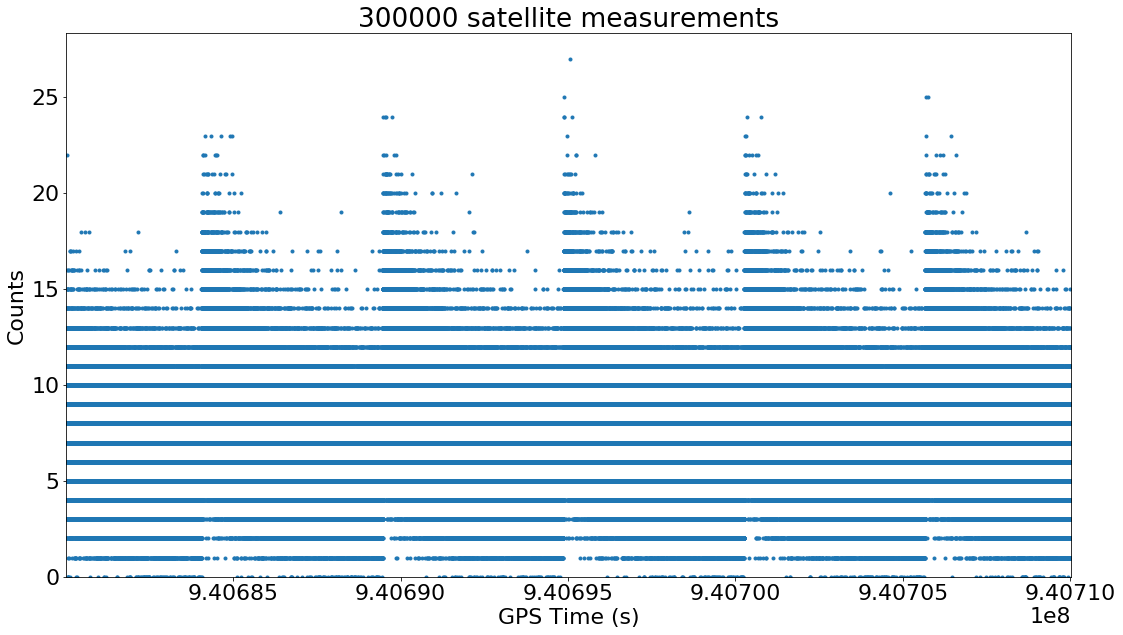

In [21]:
num_points = 300_000
plt.title(f"{num_points} satellite measurements")
plt.xlabel('GPS Time (s)')
plt.ylabel('Counts')
plt.plot(data[0][0:num_points], data[3][0:num_points], '.');
plt.xlim(data[0][0], data[0][num_points])
plt.ylim(0, None);

Clearly, the data is not random, since we see many large "jumps" in the measurements. What are some worries we may have about this data? For one thing, the spikes appear to be periodic, which means it could be encountering some additional source of radiation at some point in the orbit. Perhaps the Earth blocks the Sun for some of the orbit, and each spike is a short exposure to radiation from the Sun. 

This data clearly represents discrete measurements, though, so its distribution is likely discrete too - because each measurement represents a number of events seen in a certain time interval, a Poisson distribution seems likely. Let's plot a normalized histogram of this data to get an idea of what the measurement distribution looks like:

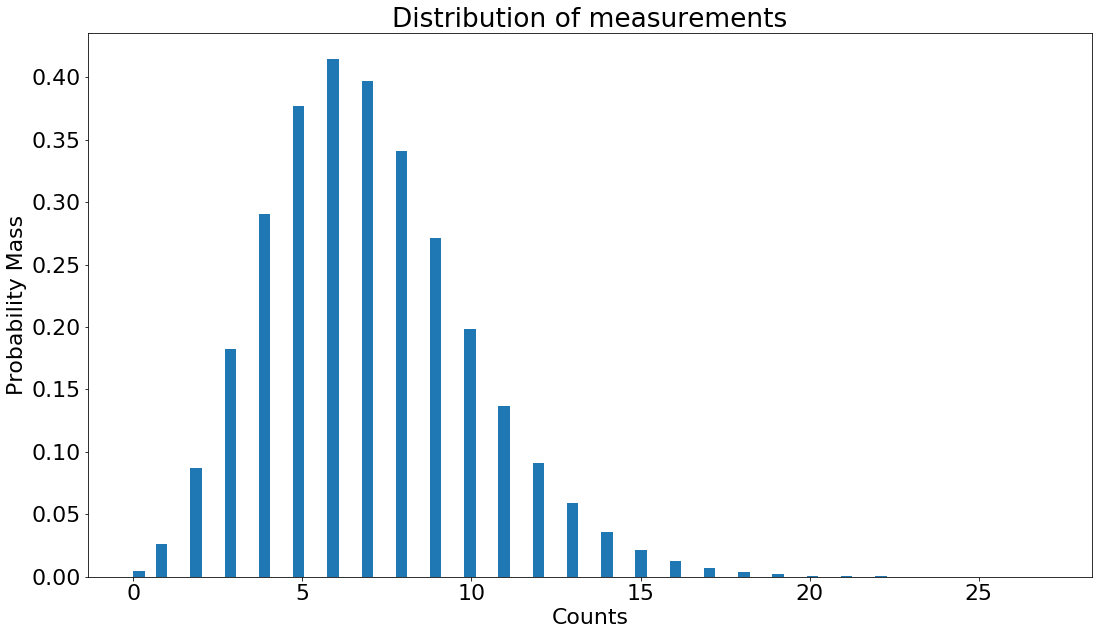

In [22]:
plt.title('Distribution of measurements')
plt.xlabel('Counts')
plt.ylabel('Probability Mass')
plt.hist(data[3][0:num_points], bins=80, density=True);

Looks fairly Poisson-like, with a mean of around 6 counts per 0.1 sec. What about when this data is viewed on a log scale with a Poisson alongside for comparison?

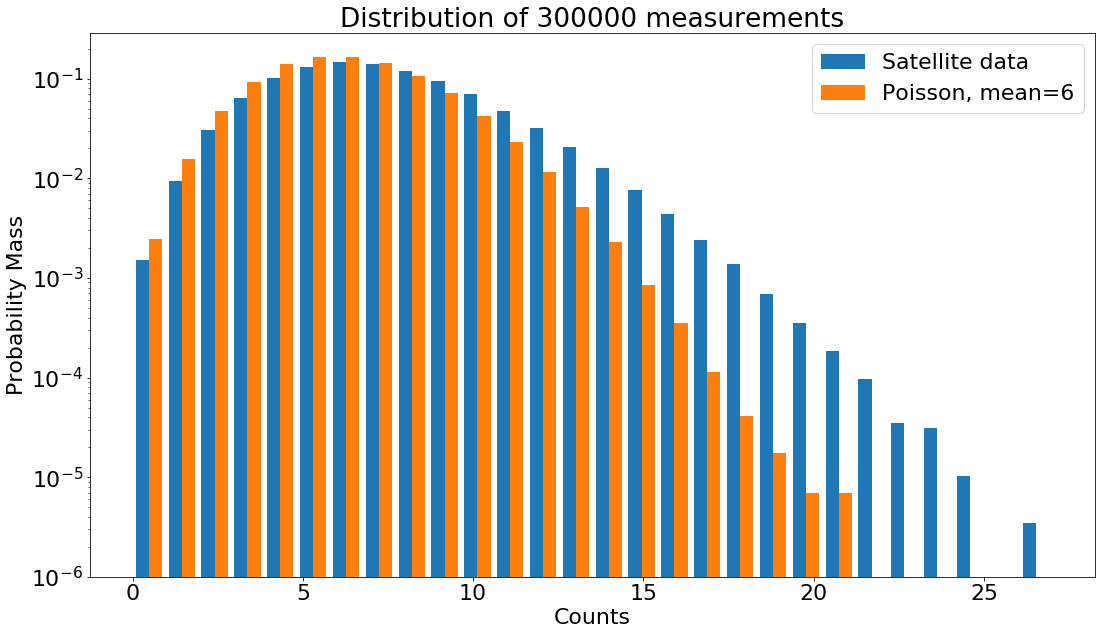

In [23]:
plt.title(f"Distribution of {num_points} measurements")
plt.xlabel('Counts')
plt.ylabel('Probability Mass')

dist = stats.poisson(6)
vals = dist.rvs(num_points)
plt.hist([data[3][0:num_points], vals], bins=28, density=True)

plt.yscale('log')
plt.ylim(1e-6, None)
plt.legend(['Satellite data', 'Poisson, mean=6']);

Definitely not Poisson-distributed - the right tail is too long, and the leftmost bins are lower in probability. This makes sense when examining the raw data - the "jumps" we see on the signal plot periodically show more counts at values further above the mean, which, at the same time, reduces the number of low-count measurements.

There appears to be some signal contamination. Let's look at the metadata on top of the raw data to see what might be going on.

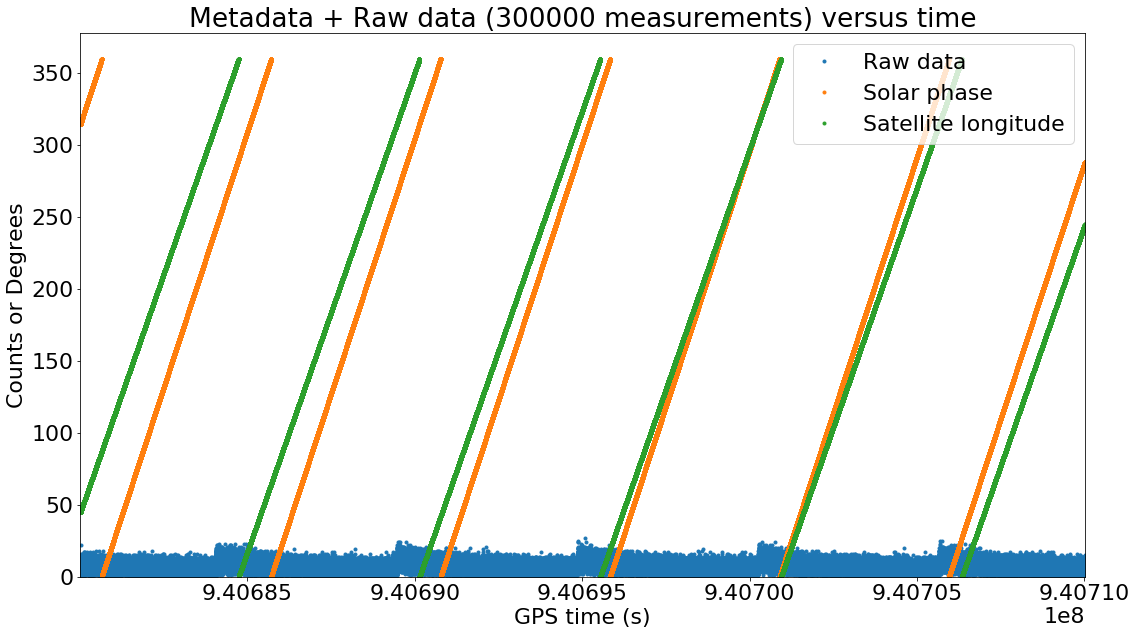

In [24]:
plt.title(f"Metadata + Raw data ({num_points} measurements) versus time")
plt.xlabel('GPS time (s)')
plt.ylabel('Counts or Degrees')
plt.plot(data[0][0:num_points], data[3][0:num_points], '.')
plt.plot(data[0][0:num_points], data[1][0:num_points], '.')
plt.plot(data[0][0:num_points], data[2][0:num_points], '.')
plt.xlim(data[0][0], data[0][num_points])
plt.ylim(0, None)
plt.legend(['Raw data', 'Solar phase', 'Satellite longitude'], loc='upper right');

Aha - the angular positions of the sun and satellite relative to the earth seem to follow a similar "spiking" pattern. The solar phase doesn't really show any kind of relationship to the periodic spikes, so it's probably safe to ignore the worry we had about the sun. However, the satellite longitude seems to line up pretty consistently with the periodic spikes in our data, albeit slightly shifted in phase. Every time the satellite is located at a longitude of around 325 degrees, we get a spike in counts. Let's confirm the match in frequencies by examining the dominant frequency in a Fourier transform for each set of data. We'll use a lot more of the data this time so the lines on our spectrum are well-resolved.

Solar phase: main frequency 0.00019743589743589742 Hz, period: 5064.935064935065 s.
Satellite longitude: main frequency 0.0001846153846153846 Hz, period: 5416.666666666667 s.
Raw data: main frequency 0.0001846153846153846 Hz, period: 5416.666666666667 s.


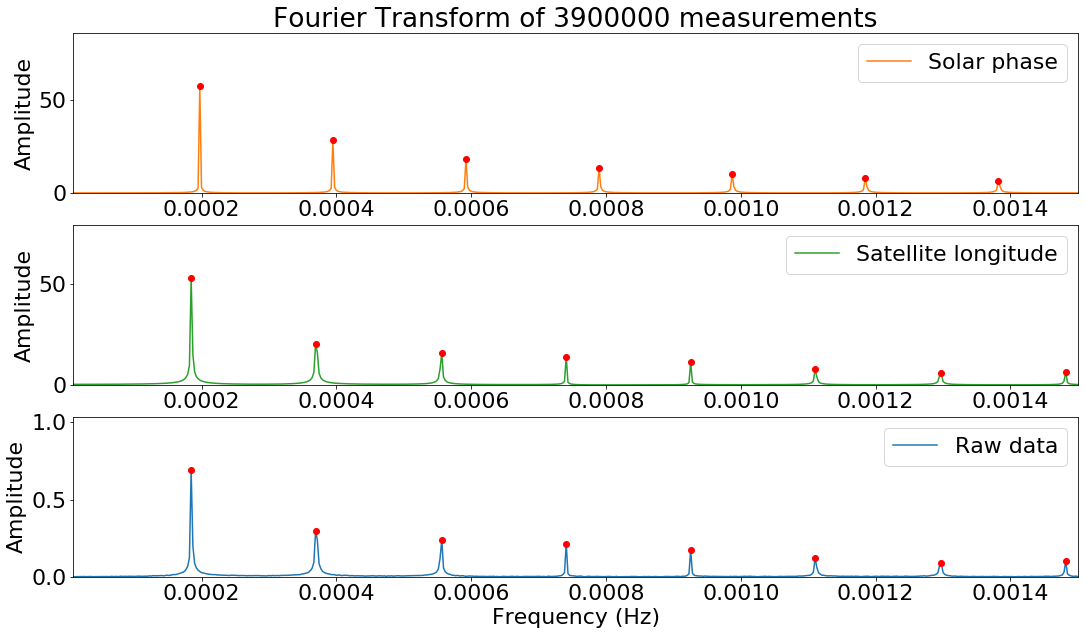

In [25]:
def get_spectrum(data, color='C0', max_order=25):
    fft = np.fft.fft(data)
    t = 0.1
    freqs = np.fft.fftfreq(len(data), t)

    x = freqs[0:len(data) // 2]
    y = np.abs(fft)[0:len(data) // 2] * 1 / len(data)

    plt.plot(x, y, color)
    maxima = argrelmax(y, order=max_order)
    plt.plot(x[maxima], y[maxima], 'ro')
    plt.xlim(1e-5, 1.5e-3)
    plt.ylim(0, y[maxima[0][0]] * 1.5);
    return x[maxima]

# We'll analyze 13 times the number of data points we used before
mul = 13
plt.subplot(3, 1, 1)
plt.title(f"Fourier Transform of {mul*num_points} measurements")
solar_phase_freqs_maxima = get_spectrum(data[1][0:mul*num_points], 'C1')
plt.ylabel('Amplitude')
plt.legend(['Solar phase'], loc='upper right')
print(f"Solar phase: main frequency {solar_phase_freqs_maxima[0]} Hz, period: {1 / solar_phase_freqs_maxima[0]} s.")
plt.subplot(3, 1, 2)
longitude_freqs_maxima = get_spectrum(data[2][0:mul*num_points], 'C2')
plt.ylabel('Amplitude')
plt.legend(['Satellite longitude'], loc='upper right')
print(f"Satellite longitude: main frequency {longitude_freqs_maxima[0]} Hz, period: {1 / longitude_freqs_maxima[0]} s.")
plt.subplot(3, 1, 3)
raw_freqs_maxima = get_spectrum(data[3][0:mul*num_points], 'C0')
plt.ylabel('Amplitude')
plt.legend(['Raw data'], loc='upper right')

plt.xlabel('Frequency (Hz)')
print(f"Raw data: main frequency {raw_freqs_maxima[0]} Hz, period: {1 / raw_freqs_maxima[0]} s.")

As we suspected, the satellite longitude data and the spikes in the raw data appear to happen at the same exact frequency, so the periodicity of the spikes in our signal (and those of the satellite longitude) is about 5400 seconds, or 90 minutes, which is the orbital period for our satellite! So every orbital period our satellite appears to be passing through some region that gives us higher cosmic ray counts. It just so happens that 325 degrees longitude runs approximately along the center of the South Atlantic Anomaly, a region where Earth's inner Van Allen radiation belts come closest to the planet's surface. This could easily explain the spikes we see in the raw data - it is significant enough that even the Hubble Space Telescope does not take data when passing through this region ([Wikipedia](https://en.wikipedia.org/wiki/South_Atlantic_Anomaly)).

Let's assume this is the cause of our signal contamination - we need to separate data taken outside the anomalous region from data taken inside. The South Atlantic Anomaly stretches from about 310 degrees longitude to 360 degrees longitude, so we'll try to split off our raw data around there.

In [26]:
# Bounds areadjusted until spikes are mostly gone. The SAA is oddly shaped so this isn't unreasonable.
no_saa_filter = (data[2] > 40) & (data[2] < 315)
gps_time_no_saa = data[0][no_saa_filter]
raw_data_no_saa = data[3][no_saa_filter]
gps_time_saa = data[0][np.invert(no_saa_filter)]
raw_data_saa = data[3][np.invert(no_saa_filter)]

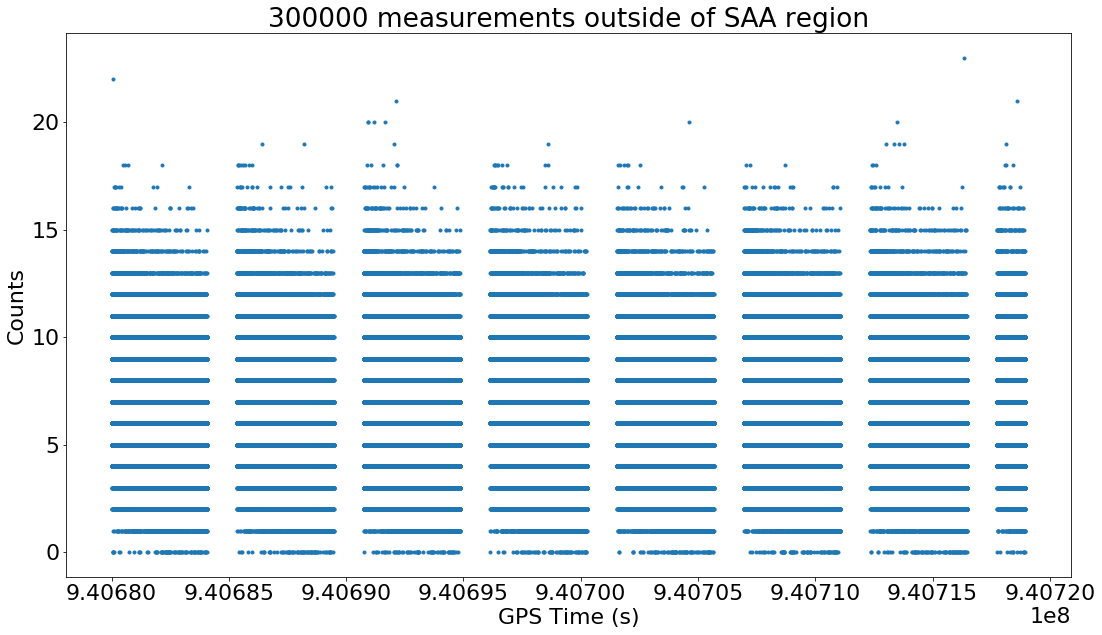

In [27]:
plt.title(f"{num_points} measurements outside of SAA region")
plt.xlabel('GPS Time (s)')
plt.ylabel('Counts')
plt.plot(gps_time_no_saa[0:num_points], raw_data_no_saa[0:num_points], 'C0.');

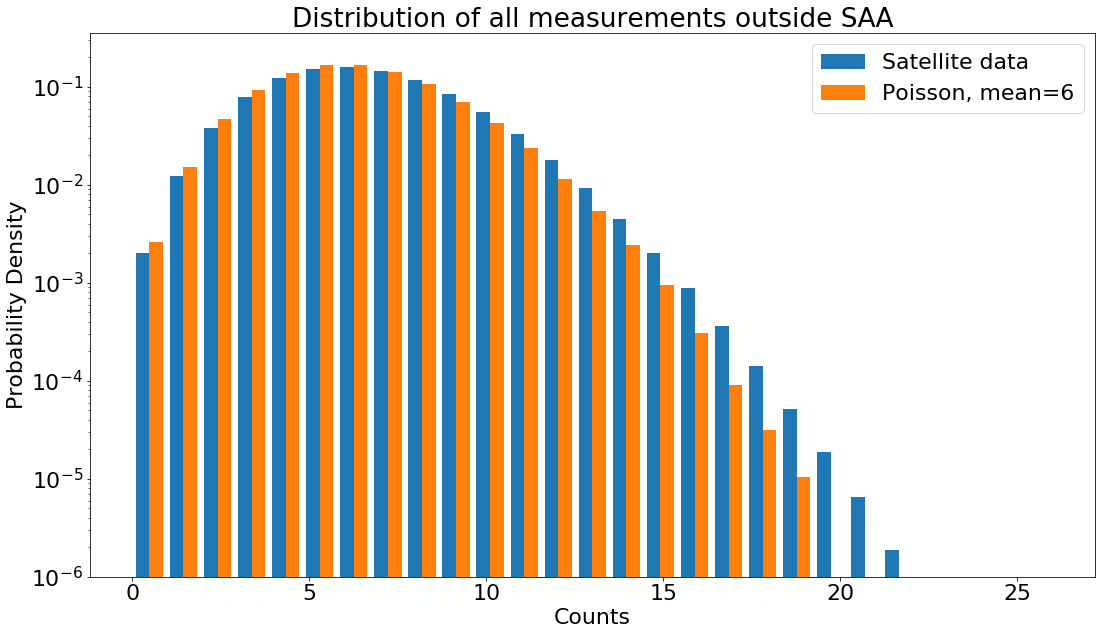

In [28]:
plt.title(f"Distribution of all measurements outside SAA")
plt.xlabel('Counts')
plt.ylabel('Probability Density')
vals = stats.poisson(6).rvs(num_points)
plt.hist([raw_data_no_saa, vals], bins=27, density=True)
plt.yscale('log')
plt.ylim(1e-6, None)
plt.legend(['Satellite data', 'Poisson, mean=6']);

Much better - the data outside the SAA is described fairly well with a Poisson distribution of mean 6 counts per 0.1 seconds. If we want to find the signal threshold to use for locating $5\sigma$ events, we use the `ppf` function like so:

In [29]:
stats.poisson(6).ppf(stats.norm.cdf(5))

22.0

This answers the question "What is the smallest signal I need to consider a measurement _outside_ the SAA to have a significance of $5\sigma$?"

Outside the SAA, a measurement of 22 counts or more will be statistically significant. What about _inside_ the SAA? Because this is a region of higher-than-average radiation, our $5\sigma$ threshold will go up periodically. Let's plot the data recorded inside the SAA and find its distribution:

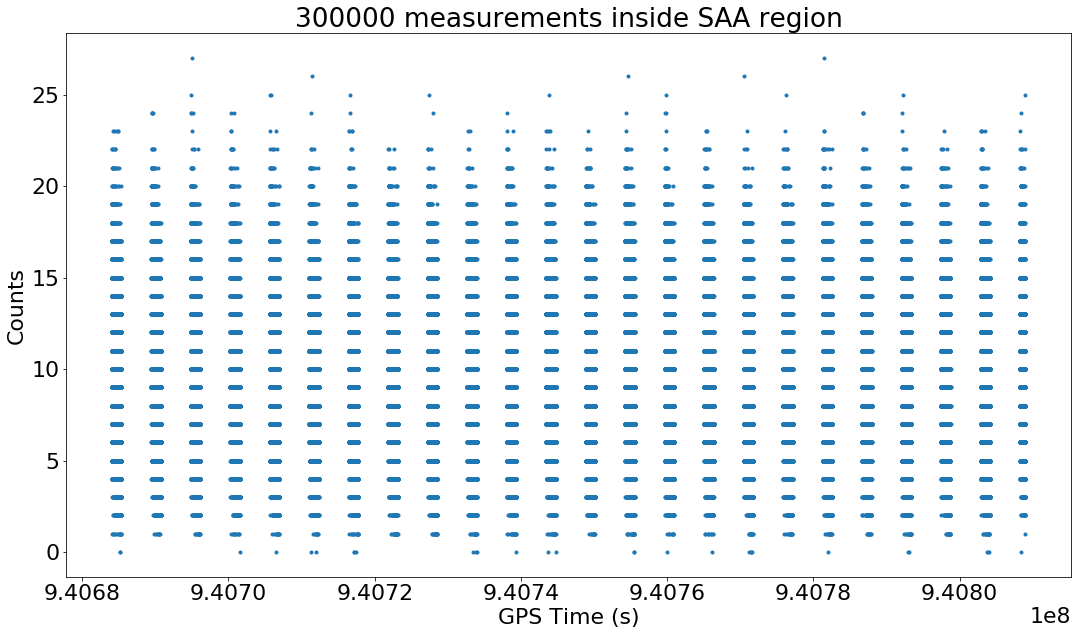

In [30]:
plt.title(f"{num_points} measurements inside SAA region")
plt.xlabel('GPS Time (s)')
plt.ylabel('Counts')
plt.plot(gps_time_saa[0:num_points], raw_data_saa[0:num_points], 'C0.');

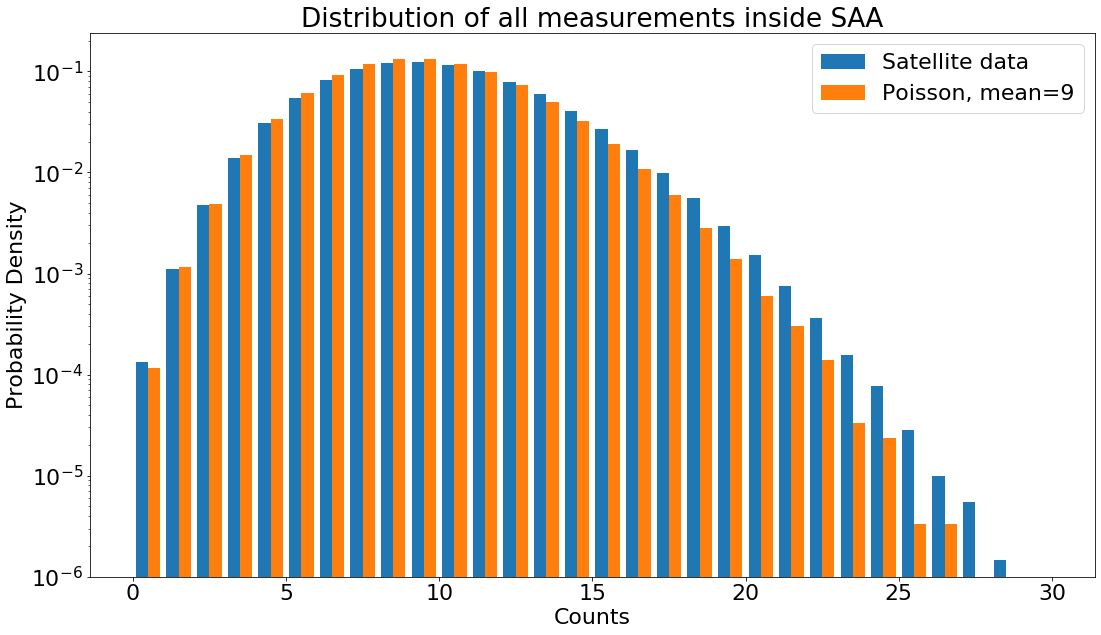

In [31]:
plt.title(f"Distribution of all measurements inside SAA")
plt.xlabel('Counts')
plt.ylabel('Probability Density')
vals = stats.poisson(9).rvs(num_points)
plt.hist([raw_data_saa, vals], bins=30, density=True)
plt.yscale('log')
plt.ylim(1e-6, None)
plt.legend(['Satellite data', 'Poisson, mean=9']);

We'll use the `ppf` function again to find the $5\sigma$ threshold for this distribution:

In [32]:
stats.poisson(9).ppf(stats.norm.cdf(5))

28.0

This answers the question "What is the smallest signal I need to consider a measurement _inside_ the SAA to have a significance of $5\sigma$?"

Inside the SAA, a measurement of 28 counts or more will be statistically significant.

## Problem 2

We have a stack of ten images from a telescope.

Let's plot one image and its distribution, and look for interesting features.

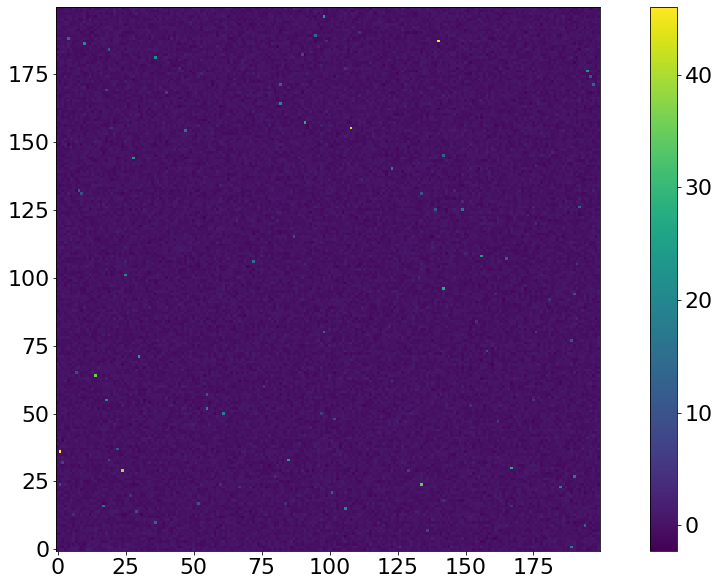

In [33]:
with h5py.File('images.h5', 'r') as hf:
    img_data = np.array(hf.get('imagestack'))

plt.imshow(img_data[:, :, 0], origin='lower')
plt.colorbar();

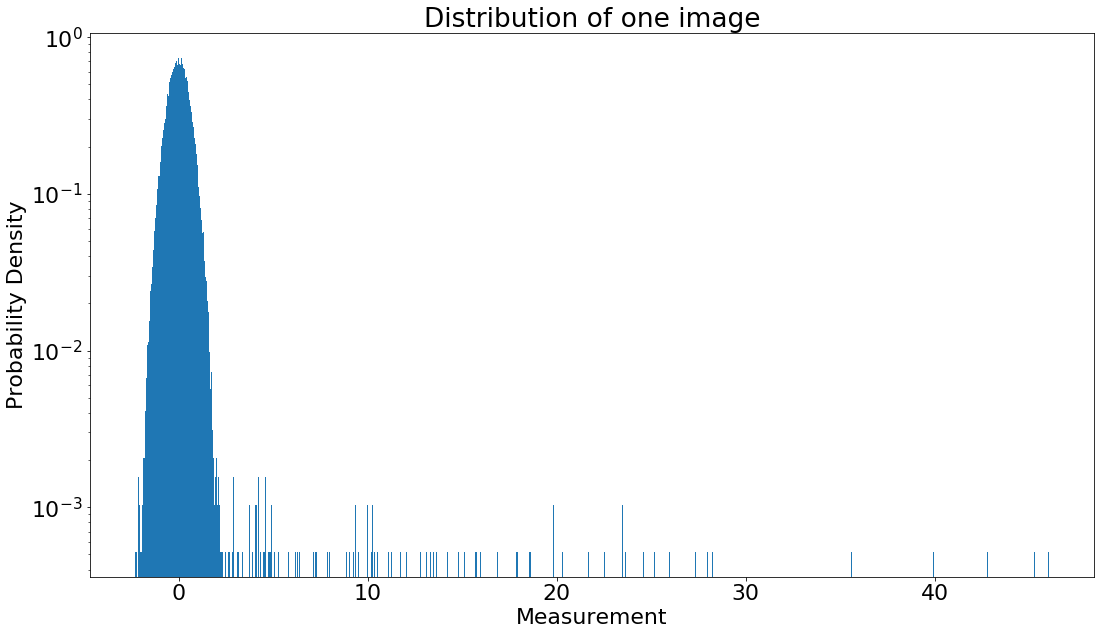

In [34]:
plt.title('Distribution of one image')
plt.xlabel('Measurement')
plt.ylabel('Probability Density')
plt.hist(img_data[:, :, 0].flatten(), bins=1000, density=True)
plt.yscale('log');

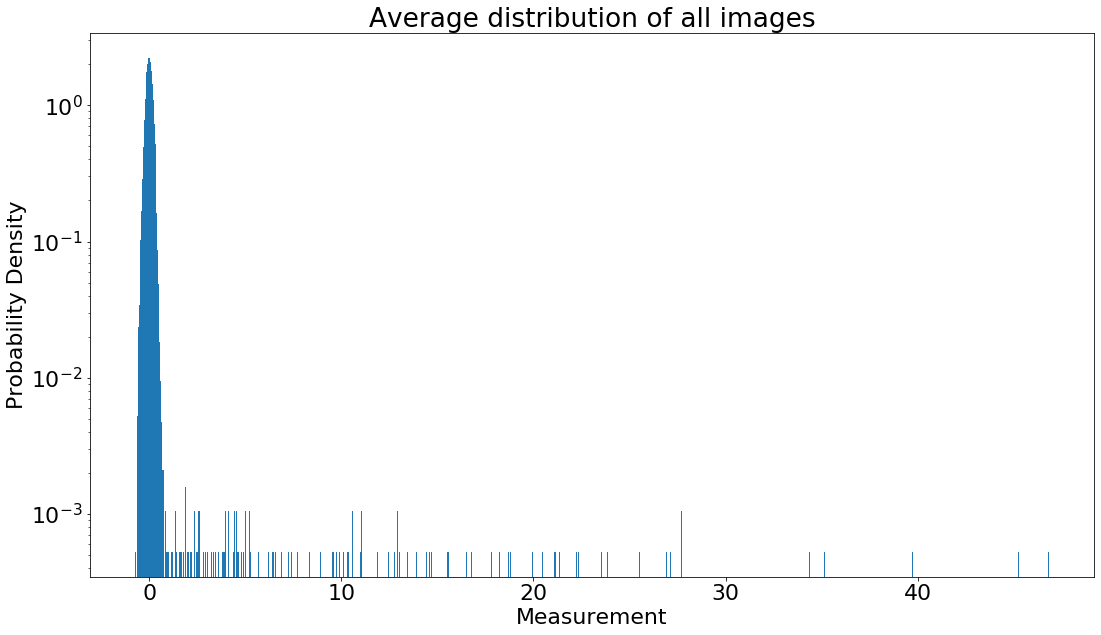

In [35]:
plt.title('Average distribution of all images')
plt.xlabel('Measurement')
plt.ylabel('Probability Density')
average_img = np.mean(img_data, axis=2)
plt.hist(average_img.flatten(), bins=1000, density=True)
plt.yscale('log');

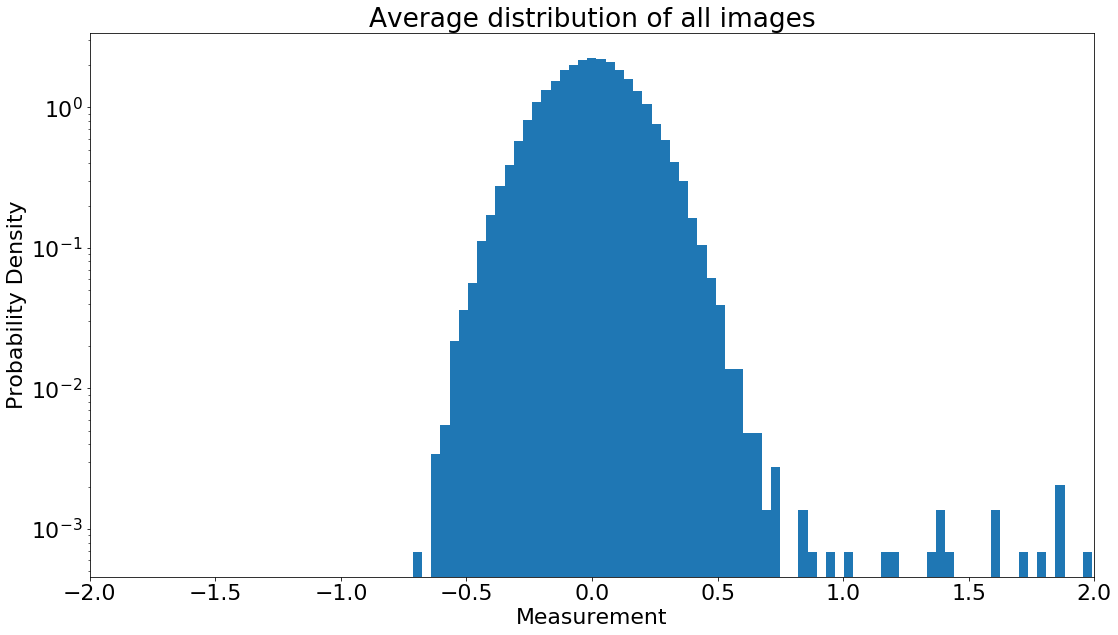

In [36]:
plt.title('Average distribution of all images')
plt.xlabel('Measurement')
plt.ylabel('Probability Density')
plt.hist(average_img.flatten(), bins=1300, density=True)
plt.xlim(-2, 2)
plt.yscale('log');